In [1]:
%pip install pyspark==3.1.1 pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.executable

'/usr/local/anaconda3/envs/ada/bin/python'

In [3]:
# Make sure that spark uses the same python distribution to avoid serialization issues due to missing packages
%env SPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
%env SPARK_DRIVER=/usr/local/anaconda3/envs/ada/bin/python

env: SPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
env: SPARK_DRIVER=/usr/local/anaconda3/envs/ada/bin/python


In [34]:
# Data handling and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark
import pyspark
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType, DoubleType

# Helpers
import os

In [91]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','8G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.sql.execution.arrow.maxRecordsPerBatch', 10000),
    ('spark.local.dir', '/tmp')
])

spark = SparkSession.builder.config(conf=conf).config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2").getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark

In [6]:
DATA_DIR = 'data/'
QUOTEBANK_DATA_DIR = DATA_DIR + 'quotebank_data/'
PROFANITY_SCORES_DIR = DATA_DIR + 'profanity_scores/'

In [7]:
def load_parquet_data(file_list):
    df_all = None
    for fn in file_list:
        df = spark.read.parquet(fn)
        if df_all:
            df_all = df_all.union(df)
        else:
            df_all = df
    return df_all

In [8]:
QB_FILE_PATTERN = QUOTEBANK_DATA_DIR + 'parquet/quotes-%s.parquet'
PROFANITY_FILE_PATTERN = PROFANITY_SCORES_DIR + 'profanity-%s.parquet'
YEARS = ['2020']

In [9]:
%%time
df_all = load_parquet_data([ (QB_FILE_PATTERN % fn) for fn in YEARS ])
df_has_spk = df_all.where(df_all.speaker != "None")

CPU times: user 6.73 ms, sys: 4.38 ms, total: 11.1 ms
Wall time: 7.22 s


In [21]:
%%time
dfp = load_parquet_data([ (PROFANITY_FILE_PATTERN % fn) for fn in YEARS ])

CPU times: user 3.18 ms, sys: 2.57 ms, total: 5.75 ms
Wall time: 441 ms


In [11]:
#dfp.head()

,profanity
quoteID,
2020-03-11-007341,0.018511
2020-01-23-009919,0.204860
2020-01-09-009596,0.063560
2020-03-30-006035,0.151097
2020-02-21-007083,0.111848


In [12]:
# Extract the yyyy-mm part from the date
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

In [13]:
def normalize(key, pdf):
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.profanity.mean() ], "sem" : [ pdf.profanity.sem() ]})

In [32]:
def plot_distribution(df, title):
    plt.figure(figsize=(15,8))
    plt.ylim(0.9 * df['mean'].min(), 1.1 * df['mean'].max())
    sns.barplot(x=df["key"], y=df["mean"], yerr=1.96*df["sem"])
    plt.xlabel("month")
    plt.ylabel("average profanity with 95% error bars")
    plt.title(title)
    plt.show()


In [90]:
d = df_has_spk.join(dfp, 'quoteID')
# d.write.parquet(DATA_DIR + 'qb_with_profanity.parquet', 'overwrite')

In [26]:
df_has_spk = spark.read.parquet(DATA_DIR + 'qb_with_profanity.parquet')

In [28]:
%%time
d1 = df_has_spk \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

CPU times: user 219 ms, sys: 177 ms, total: 396 ms
Wall time: 1min 54s


In [38]:
%%time
d2 = df_has_spk \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .where( (df_has_spk.speaker != "President Donald Trump") \
               & (df_has_spk.speaker != "President Trump") \
               & (df_has_spk.speaker != "Donald Trump") ) \
        .groupby("date") \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

CPU times: user 169 ms, sys: 122 ms, total: 291 ms
Wall time: 2min 4s


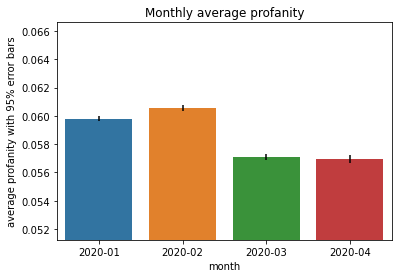

In [35]:
plot_distribution(d1, "Monthly average profanity")

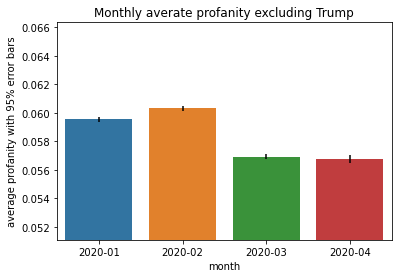

In [39]:
plot_distribution(d2, "Monthly averate profanity excluding Trump")

In [69]:
d1['kind'] = 'With Trump'

In [68]:
d2['kind'] = 'Without Trump'

(0.05621509567879259, 0.061163448274884874)

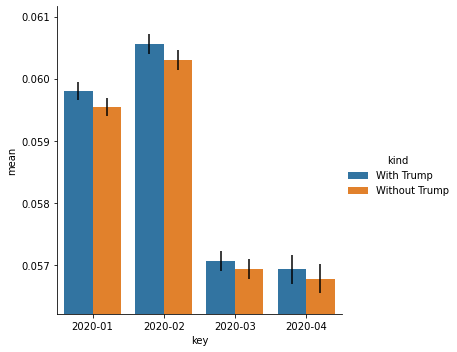

In [88]:
d = pd.concat([d1, d2])
sns.catplot(x='key', y='mean', hue='kind', data=d, kind='bar', yerr=1.6 * d1['sem'])
plt.ylim(0.99 * d['mean'].min(), 1.01 * d['mean'].max())